#imports

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
!pip install optuna

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import pickle
import matplotlib.ticker as ticker
import optuna
from imblearn.over_sampling import SMOTE


#Εισαγωγή datasset

Το dataset αφορά εταιρείες της Ασίας και συγκεκριμένα δεδομένα που αντλήθηκαν από το Taiwan Economic Journal την περίοδο του 1999 με 2009. Το χαρακτηριστικό που θα προσπαθήσουμε να προβλέψουμε είναι το εάν η εταιρεία χρεοκόπησε ή οχι.

In [63]:
file_name = 'drive/MyDrive/NEURAL/first/kaggle/bankruptcy.csv'
bankruptcy_df = pd.read_csv(file_name)

In [64]:
bankruptcy_df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

Είδαμε στο dataset ότι το  Net Income Flag έχει σταθερή τιμή 1, οπότε το κάνουμε drop

In [65]:
bankruptcy_df[' Net Income Flag'].value_counts()

1    6819
Name:  Net Income Flag, dtype: int64

In [66]:
bankruptcy_df.drop([' Net Income Flag'], axis=1)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.127236,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,2.394682e-02,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,2.550000e+07,0.458521,7.900790e-04,0.000000,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.26

Το label βρίσκεται στην πρώτη θέση. Επίσης όλα μας τα δεδομένα είναι αριθμητικά, οπότε δεν χρειάζεται να κάνουμε κάποια μετατροπή.

In [67]:
rows_count, columns_count = bankruptcy_df.shape
print('Total Number of rows :', rows_count)
print('Total Number of columns :', columns_count)

Total Number of rows : 6819
Total Number of columns : 96


In [68]:
bankruptcy_df.isnull().sum().sum()

0

Επίσης δεν έχουμε καμμία κενή τιμή, που μας κάνει την ζωή εύκολη.

In [69]:
bankruptcy_df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

Βλέπουμε ότι το dataset είναι υπερβολικά unbalanced, με τις εταιρείες που χρεοκόπησαν να είναι η μειοψηφία.

In [70]:
X = bankruptcy_df.iloc[:,1:96]
y = bankruptcy_df.iloc[:,0]

In [71]:
X.shape

(6819, 95)

In [72]:
y.shape

(6819,)

#Out of box classifiers

Θα τρέξουμε τους ταξινομητές μας για διάφορα train test split για να δούμε ποιό εξυπηρετεί καλύτερα το dataset.

In [73]:
out_of_the_box_data = {}

##MLP

In [74]:
test_splits = [0.15,0.2,0.25,0.3,0.4]

for test_split in test_splits:
    name = "MLP_"+ str(test_split)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = test_split,random_state = 10)
    clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy =accuracy_score(y_test,predictions)
    recall = recall_score(y_test,predictions)
    f1 = f1_score(y_test,predictions,average='macro')
    accuracy_score_balanced = balanced_accuracy_score(y_test,predictions)
    out_of_the_box_data[name] = (predictions,accuracy,recall,f1,accuracy_score_balanced)
    print("For test size ",test_split, " Accuracy : ",accuracy)
    print("For test size ",test_split, " Recall :   ",recall)
    print("For test size ",test_split, " F1 :       ",f1)
    print("For test size ",test_split, " balanced_accuracy_score :       ",accuracy_score_balanced)


For test size  0.15  Accuracy :  0.9550342130987293
For test size  0.15  Recall :    0.02631578947368421
For test size  0.15  F1 :        0.509321821821822
For test size  0.15  balanced_accuracy_score :        0.5085893668180604
For test size  0.2  Accuracy :  0.9413489736070382
For test size  0.2  Recall :    0.09803921568627451
For test size  0.2  F1 :        0.5403925532811052
For test size  0.2  balanced_accuracy_score :        0.5360721592521244
For test size  0.25  Accuracy :  0.9249266862170088
For test size  0.25  Recall :    0.05
For test size  0.25  F1 :        0.502852040165473
For test size  0.25  balanced_accuracy_score :        0.503419452887538
For test size  0.3  Accuracy :  0.9389051808406648
For test size  0.3  Recall :    0.0684931506849315
For test size  0.3  F1 :        0.5212422430011513
For test size  0.3  balanced_accuracy_score :        0.5198015677398302
For test size  0.4  Accuracy :  0.9149560117302052
For test size  0.4  Recall :    0.16129032258064516
For 

##SVC

In [75]:
for test_split in test_splits:
    name = "SVC_"+ str(test_split)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = test_split,random_state = 10)
    clf = SVC().fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy =accuracy_score(y_test,predictions)
    recall = recall_score(y_test,predictions)
    f1 = f1_score(y_test,predictions,average='macro')
    accuracy_score_balanced =balanced_accuracy_score(y_test,predictions)
    out_of_the_box_data[name] = (predictions,accuracy,recall,f1,accuracy_score_balanced)
    print("For test size ",test_split, " Accuracy : ",accuracy)
    print("For test size ",test_split, " Recall :   ",recall)
    print("For test size ",test_split, " F1 :       ",f1)
    print("For test size ",test_split, " balanced_accuracy_score :       ",accuracy_score_balanced)

For test size  0.15  Accuracy :  0.9628543499511242
For test size  0.15  Recall :    0.0
For test size  0.15  F1 :        0.4905378486055777
For test size  0.15  balanced_accuracy_score :        0.5
For test size  0.2  Accuracy :  0.9626099706744868
For test size  0.2  Recall :    0.0
For test size  0.2  F1 :        0.4904744116548375
For test size  0.2  balanced_accuracy_score :        0.5
For test size  0.25  Accuracy :  0.9648093841642229
For test size  0.25  Recall :    0.0
For test size  0.25  F1 :        0.491044776119403
For test size  0.25  balanced_accuracy_score :        0.5
For test size  0.3  Accuracy :  0.9643206256109482
For test size  0.3  Recall :    0.0
For test size  0.3  F1 :        0.4909181388405076
For test size  0.3  balanced_accuracy_score :        0.5
For test size  0.4  Accuracy :  0.9659090909090909
For test size  0.4  Recall :    0.0
For test size  0.4  F1 :        0.49132947976878616
For test size  0.4  balanced_accuracy_score :        0.5


##BAR PLOTS

###BAR PLOT FUNCTION DEFINITION

In [76]:
def BarPlots(keys,accuracies,recalls,F1s,balanced_accs):
  fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4,figsize=(18,6))


  ax1.tick_params(axis='x', rotation=45)
  ax1.set_title('Accuracies')
  ax1.bar(keys, accuracies)
    
    
  ax2.tick_params(axis='x', rotation=45)
  ax2.set_title('Recall')
  ax2.bar(keys, recalls)

  ax3.tick_params(axis='x', rotation=45)
  ax3.set_title('F1 Macro')
  ax3.bar(keys, F1s)
    
  ax4.tick_params(axis='x', rotation=45)
  ax4.set_title('balanced_accuracy_score')
  ax4.bar(keys, balanced_accs)



In [77]:
out_of_the_box_accuracies =[]
out_of_the_box_F1s =[]
out_of_the_box_recalls = []
out_of_the_box_recalls_balanced_acs =[]
for key in out_of_the_box_data:
    out_of_the_box_accuracies.append(out_of_the_box_data[key][1])
    out_of_the_box_recalls.append(out_of_the_box_data[key][2])
    out_of_the_box_F1s.append(out_of_the_box_data[key][3])
    out_of_the_box_recalls_balanced_acs.append(out_of_the_box_data[key][4])

    


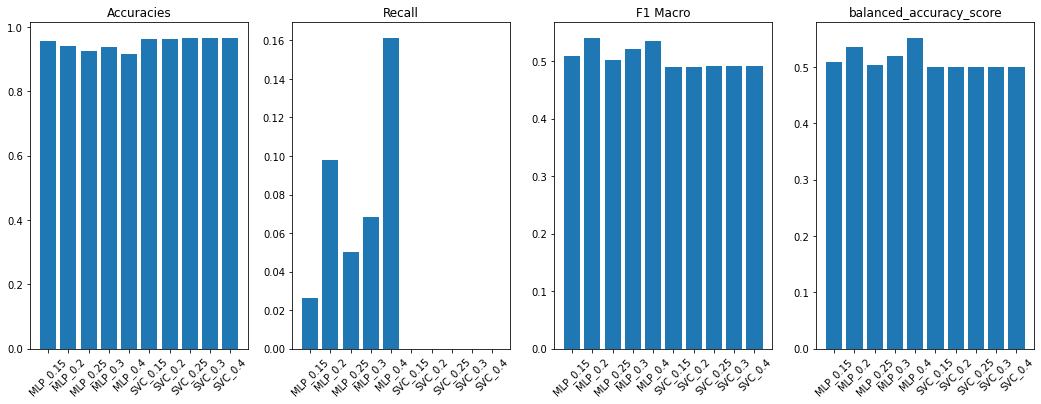

In [78]:
BarPlots(out_of_the_box_data.keys(),out_of_the_box_accuracies,out_of_the_box_recalls,out_of_the_box_F1s,out_of_the_box_recalls_balanced_acs)

##MARK DOWN TABLE

###MARK DOWN FUNCTION DEFINITION

In [ ]:
def markdownGenerator():
  names = ['Accuracies','Recall','F1','Balanced Accuracy Score']
  header = '| |'
  for name in names:
    header = header+" " +name+' |'

  print(header)

  split = '|--|'
  for _ in names:
    split = split+ '--|'

  print(split)
  keys = out_of_the_box_data.keys()
  for key in keys:
    line = '|'+key+'|'
    for i in range(1,5):
        line = line+ str(out_of_the_box_data[key][i]) + '|'
    print(line)


In [80]:
markdownGenerator()

| | Accuracies | Recall | F1 | Balanced Accuracy Score |
|--|--|--|--|--|
|MLP_0.15|0.9550342130987293|0.02631578947368421|0.509321821821822|0.5085893668180604|
|MLP_0.2|0.9413489736070382|0.09803921568627451|0.5403925532811052|0.5360721592521244|
|MLP_0.25|0.9249266862170088|0.05|0.502852040165473|0.503419452887538|
|MLP_0.3|0.9389051808406648|0.0684931506849315|0.5212422430011513|0.5198015677398302|
|MLP_0.4|0.9149560117302052|0.16129032258064516|0.5349184467103851|0.5514231499051233|
|SVC_0.15|0.9628543499511242|0.0|0.4905378486055777|0.5|
|SVC_0.2|0.9626099706744868|0.0|0.4904744116548375|0.5|
|SVC_0.25|0.9648093841642229|0.0|0.491044776119403|0.5|
|SVC_0.3|0.9643206256109482|0.0|0.4909181388405076|0.5|
|SVC_0.4|0.9659090909090909|0.0|0.49132947976878616|0.5|


| | Accuracies | Recall | F1 | Balanced Accuracy Score |
|--|--|--|--|--|
|MLP_0.15|0.9550342130987293|0.02631578947368421|0.509321821821822|0.5085893668180604|
|MLP_0.2|0.9413489736070382|0.09803921568627451|0.5403925532811052|0.5360721592521244|
|MLP_0.25|0.9249266862170088|0.05|0.502852040165473|0.503419452887538|
|MLP_0.3|0.9389051808406648|0.0684931506849315|0.5212422430011513|0.5198015677398302|
|MLP_0.4|0.9149560117302052|0.16129032258064516|0.5349184467103851|0.5514231499051233|
|SVC_0.15|0.9628543499511242|0.0|0.4905378486055777|0.5|
|SVC_0.2|0.9626099706744868|0.0|0.4904744116548375|0.5|
|SVC_0.25|0.9648093841642229|0.0|0.491044776119403|0.5|
|SVC_0.3|0.9643206256109482|0.0|0.4909181388405076|0.5|
|SVC_0.4|0.9659090909090909|0.0|0.49132947976878616|0.5|



Τα συνεχή μηδενικά στον SVC είναι λίγο ύποπτα, οπότε κάνουμε έναν έλεγχο.

In [ ]:
len(out_of_the_box_data['SVC_0.15'][0])

1023

In [ ]:
np.count_nonzero(out_of_the_box_data['SVC_0.15'][0])

0

##Συμπεράσματα

Βλέπουμε ότι καθώς το dataset είναι πάρα πολύ unbalanced, και οι δύο Classifiers, αλλα κυρίως ο SVC αναγνωρίζει ότι εάν τείνει στον dummy constant 0 θα βρεί αρκετά καλό accuracy. Για αυτό τον λόγο θα δουλέψουμε με recall , F1 και balanced accuracy score. Από τις παραπάνω δοκιμές βλέπουμε ότι η καλύτερη τιμή του test score για τις μετρικές που μας ενδιαφέρουν είναι 60% - 40 %.  

#Data process

##Correlation Threshold

Με μία πρώτη ανάγνωση του dataset βλέπουμε ότι υπάρχουν αρκετές παράμετροι έχουν ισχυρό συσχετισμό μεταξύ τους. Για αυτό τον λόγο θεωρήσαμε ότι θα ήταν καλό να κάνουμε drop τις στήλες που ευθύνονται για μικρό ποσοστό του variance. Για αυτόν τον λόγο θα χρησιμοποιήσουμε μία συνάρτηση από το stack overflow που κάνει αυτή την δουλειά.

In [ ]:
#https://stackoverflow.com/a/51658973/11333604

def corr_df(x, corr_val=0.6):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
    return x

In [ ]:
X = corr_df(X)

 ROA(B) before interest and depreciation after tax |  ROA(C) before interest and depreciation before interest | 0.99
 After-tax net Interest Rate |  Operating Profit Rate | 0.86
 Continuous interest rate (after tax) |  Operating Profit Rate | 0.92
 Continuous interest rate (after tax) |  Pre-tax net Interest Rate | 0.99
 Continuous interest rate (after tax) |  After-tax net Interest Rate | 0.98
 Net Value Per Share (C) |  Net Value Per Share (B) | 1.0
 Persistent EPS in the Last Four Seasons |  ROA(C) before interest and depreciation before interest | 0.78
 Persistent EPS in the Last Four Seasons |  ROA(A) before interest and % after tax | 0.76
 Persistent EPS in the Last Four Seasons |  ROA(B) before interest and depreciation after tax | 0.76
 Persistent EPS in the Last Four Seasons |  Net Value Per Share (B) | 0.76
 Persistent EPS in the Last Four Seasons |  Net Value Per Share (A) | 0.76
 Operating Profit Per Share (Yuan ¥) |  ROA(C) before interest and depreciation before interest 

In [ ]:
X.shape

(6819, 64)

Βλέπουμε ότι κόβει περίπου 30 στοιχεία. το οποία λογικά θα κάνει την εκπαίδευση αρκετά πιο γρήγορη.

##Variance Threshold

In [ ]:
selector = VarianceThreshold()
X = selector.fit_transform(X)

In [ ]:
X.shape

(6819, 63)

Το variance threshold κόβει μόνο μία στήλη.

#Smote


Το κυριότερο πρόβλημα του dataset είναι ότι είναι ακραία unbalanced. Για αυτό, όπως βλέπουμε και στο hottest kaggle notebook για αυτό το dataset, θα κάνουμε oversampling στην κλάση 1, για να έχουμε ίσο αριθμό instances. 
Θα τον SVC δοκιμάσουμε λοιπόν στα νέα δεδομένα, μιάς και ήταν το worst case scenario στην προηγούμενη περίπτωση. Test size θα βάλουμε 0.4, στο οποία είχαμε την καλύτεη συμπεριφορά του MLP.

In [ ]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print('New balance of 1 and 0 classes (%):')
y_sm.value_counts()

# https://www.kaggle.com/petrkolar/ml-workflow-0-99-f1

New balance of 1 and 0 classes (%):


1    6599
0    6599
Name: Bankrupt?, dtype: int64

####Smote SVC test

In [ ]:
test_split = 0.4
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm,test_size = test_split,random_state = 10)

clf= SVC().fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy =accuracy_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions,average='macro')
accuracy_score_balanced =balanced_accuracy_score(y_test,predictions)
print("For test size ",test_split, " Accuracy : ",accuracy)
print("For test size ",test_split, " Recall :   ",recall)
print("For test size ",test_split, " F1 :       ",f1)
print("For test size ",test_split, " balanced_accuracy_score :       ",accuracy_score_balanced)

For test size  0.4  Accuracy :  0.8185606060606061
For test size  0.4  Recall :    0.871264367816092
For test size  0.4  F1 :        0.8182275809201057
For test size  0.4  balanced_accuracy_score :        0.8191527831589823


Βλέπουμε φοβερή βελτίωση ως προς την συμπερφορά του ως προς τις προβλέψεις 0. Τώρα θα ψάξουμε και για τις υπόλοιπες υπερπαραμέτους. 

#Optuna GridSearch

Θα χρησιμοποιήσουμε το optuna για να βρούμε τις καλύτερες υπερπαραμέτρους.

In [ ]:
def objective(trial):
  #PREPROCESSING
  pipelineList =[]
  StandardScalerChoice = trial.suggest_int('StandardScaler',0,1)
  if StandardScalerChoice:
          pipelineList.append(['scaler', StandardScaler()])


  test_splits = trial.suggest_discrete_uniform('test size',0.1,0.4,0.1)
  x_train,x_test,y_train,y_test = train_test_split(X_sm,y_sm,test_size=test_splits)


  classifier_name = trial.suggest_categorical("classifier", ["SVC","MLP"])


  if classifier_name == "SVC":
    C = trial.suggest_loguniform('C', 1e-10, 1)
    kernel = trial.suggest_categorical('kernel',['rbf','sigmoid'])
    gamma = trial.suggest_categorical('gamma',['auto','scale'])
    
    pipelineList.append(['svc',SVC(C=C, kernel=kernel,gamma=gamma)])



  if classifier_name == "MLP":

    alpha = trial.suggest_loguniform('alpha',1e-13,1e-8)
    solver = trial.suggest_categorical('solver',['sgd','adam'])
    activation = trial.suggest_categorical('activation',['logistic','tanh','relu'])
    learning_rate = trial.suggest_categorical('learning_rate',['constant','adaptive'])

    pipelineList.append(['mlp',MLPClassifier(alpha=alpha, solver=solver, activation=activation,learning_rate=learning_rate)])

  clf =Pipeline(steps = pipelineList) 

  clf.fit(x_train,y_train)

  # Evaluate the model
  y_pred_test = clf.predict(x_test)
  accuracy =accuracy_score(y_test,y_pred_test)
  f1 = f1_score(y_test,y_pred_test,average='macro')
  return f1, accuracy
  

Θα σώσουμε τα trials σε ένα pickle αρχείο, όχι ως μέρος της άσκσησς αλλά για να μπορέσουμε να το αφήσουμε και να αναλύσουμε τα δεδομένα άλλη φορά.

In [ ]:
study = optuna.create_study(directions=['maximize','maximize'])

study.optimize(objective, n_trials=200)


studyFileName = 'drive/MyDrive/NEURAL/first/kaggle/study' 
outfile = open(studyFileName,'wb')
pickle.dump(study.get_trials(),outfile)
outfile.close()

[I 2021-12-02 18:40:45,948] A new study created in memory with name: no-name-f5e230c1-7186-495d-a773-e6c61f2f9b1a
[I 2021-12-02 18:40:54,321] Trial 0 finished with values: [0.8234831421962766, 0.8265151515151515] and parameters: {'StandardScaler': 0, 'test size': 0.4, 'classifier': 'MLP', 'alpha': 2.4029040031714865e-13, 'solver': 'adam', 'activation': 'relu', 'learning_rate': 'adaptive'}. 
[I 2021-12-02 18:41:18,599] Trial 1 finished with values: [0.6539663486413212, 0.6545454545454545] and parameters: {'StandardScaler': 0, 'test size': 0.1, 'classifier': 'MLP', 'alpha': 1.5391091063127621e-12, 'solver': 'sgd', 'activation': 'logistic', 'learning_rate': 'adaptive'}. 
[I 2021-12-02 18:41:20,664] Trial 2 finished with values: [0.5920433473313396, 0.5920454545454545] and parameters: {'StandardScaler': 0, 'test size': 0.4, 'classifier': 'MLP', 'alpha': 8.253855370372395e-12, 'solver': 'adam', 'activation': 'tanh', 'learning_rate': 'constant'}. 
[I 2021-12-02 18:41:22,608] Trial 3 finished

#Results

In [7]:
trialsFile = 'drive/MyDrive/NEURAL/first/kaggle/study' 
with open(trialsFile, 'rb') as handle:
    trials = pickle.load(handle)

Χωρίζουμε τα δεδομένα με βάση τον classifier

In [10]:
MLPs = []
SVCs =[]

for trial in trials:
  if trial.params['classifier'] == 'MLP':
    MLPs.append(trial)
  elif trial.params['classifier'] =='SVC':
    SVCs.append(trial)

Κάνουμε sort με βάση το f1 score, για να δούμε τις ακραίες περιπρώσεις.

###MLP outliers

In [11]:
MLPs.sort(key = lambda key:key.values[0])

In [12]:
MLPsWorse = MLPs[:5]

In [13]:
MLPsBest = MLPs[-5:]

In [49]:
MLPsWorse

[FrozenTrial(number=105, values=[0.3330807123910572, 0.4994318181818182], datetime_start=datetime.datetime(2021, 12, 2, 19, 3, 57, 813600), datetime_complete=datetime.datetime(2021, 12, 2, 19, 4, 1, 265050), params={'StandardScaler': 0, 'test size': 0.4, 'classifier': 'MLP', 'alpha': 8.253855370372395e-12, 'solver': 'sgd', 'activation': 'relu', 'learning_rate': 'adaptive'}, distributions={'StandardScaler': IntUniformDistribution(high=1, low=0, step=1), 'test size': DiscreteUniformDistribution(high=0.4, low=0.1, q=0.1), 'classifier': CategoricalDistribution(choices=('SVC', 'MLP')), 'alpha': LogUniformDistribution(high=1e-08, low=1e-13), 'solver': CategoricalDistribution(choices=('sgd', 'adam')), 'activation': CategoricalDistribution(choices=('logistic', 'tanh', 'relu')), 'learning_rate': CategoricalDistribution(choices=('constant', 'adaptive'))}, user_attrs={}, system_attrs={'nsga2:generation': 2, 'nsga2:parents': [86, 56]}, intermediate_values={}, trial_id=105, state=TrialState.COMPLET

In [14]:
MLPsBest

[FrozenTrial(number=123, values=[0.9882531919410351, 0.9882575757575758], datetime_start=datetime.datetime(2021, 12, 2, 19, 9, 14, 468997), datetime_complete=datetime.datetime(2021, 12, 2, 19, 9, 29, 383467), params={'StandardScaler': 1, 'test size': 0.2, 'classifier': 'MLP', 'alpha': 1.340640463015051e-12, 'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant'}, distributions={'StandardScaler': IntUniformDistribution(high=1, low=0, step=1), 'test size': DiscreteUniformDistribution(high=0.4, low=0.1, q=0.1), 'classifier': CategoricalDistribution(choices=('SVC', 'MLP')), 'alpha': LogUniformDistribution(high=1e-08, low=1e-13), 'solver': CategoricalDistribution(choices=('sgd', 'adam')), 'activation': CategoricalDistribution(choices=('logistic', 'tanh', 'relu')), 'learning_rate': CategoricalDistribution(choices=('constant', 'adaptive'))}, user_attrs={}, system_attrs={'nsga2:generation': 2, 'nsga2:parents': [45, 54]}, intermediate_values={}, trial_id=123, state=TrialState.COMPL

###SVC outliers

In [51]:
SVCs.sort(key = lambda key:key.values[0])

In [52]:
SVCsWorse = SVCs[:5]

In [53]:
SVCsBest = SVCs[-5:]

In [54]:
SVCsWorse

[FrozenTrial(number=4, values=[0.31712364200724263, 0.4643939393939394], datetime_start=datetime.datetime(2021, 12, 2, 18, 41, 22, 611361), datetime_complete=datetime.datetime(2021, 12, 2, 18, 41, 33, 545491), params={'StandardScaler': 0, 'test size': 0.1, 'classifier': 'SVC', 'C': 0.01192107798646013, 'kernel': 'sigmoid', 'gamma': 'auto'}, distributions={'StandardScaler': IntUniformDistribution(high=1, low=0, step=1), 'test size': DiscreteUniformDistribution(high=0.4, low=0.1, q=0.1), 'classifier': CategoricalDistribution(choices=('SVC', 'MLP')), 'C': LogUniformDistribution(high=1.0, low=1e-10), 'kernel': CategoricalDistribution(choices=('rbf', 'sigmoid')), 'gamma': CategoricalDistribution(choices=('auto', 'scale'))}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=4, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=14, values=[0.32342388518708354, 0.478030303030303], datetime_start=datetime.datetime(2021, 12, 2, 18, 43, 21, 71674), dat

In [56]:
SVCsBest

[FrozenTrial(number=144, values=[0.8875977823346244, 0.8878787878787879], datetime_start=datetime.datetime(2021, 12, 2, 19, 13, 40, 753894), datetime_complete=datetime.datetime(2021, 12, 2, 19, 13, 49, 19652), params={'StandardScaler': 1, 'test size': 0.30000000000000004, 'classifier': 'SVC', 'C': 0.01174839762618421, 'kernel': 'rbf', 'gamma': 'auto'}, distributions={'StandardScaler': IntUniformDistribution(high=1, low=0, step=1), 'test size': DiscreteUniformDistribution(high=0.4, low=0.1, q=0.1), 'classifier': CategoricalDistribution(choices=('SVC', 'MLP')), 'C': LogUniformDistribution(high=1.0, low=1e-10), 'kernel': CategoricalDistribution(choices=('rbf', 'sigmoid')), 'gamma': CategoricalDistribution(choices=('auto', 'scale'))}, user_attrs={}, system_attrs={'nsga2:generation': 2, 'nsga2:parents': [96, 80]}, intermediate_values={}, trial_id=144, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=133, values=[0.8961214420990776, 0.8962121212121212], datetime_start=datetime.dat

##Graph Functions

###Discreet parameters

Θα κρίνουμε την επίδραση κάθε παραμέτρου ξεχωριστά με βάση την μέση τιμή των F1 σε όλα τα trials.

In [15]:
#υπολογίζει τον μέσο όρο για μία μεταβλητή
def meansDicreetParams(trials,name,value):
  sum = 0
  counter = 0
  for clf in trials:
    if clf.params[name] ==value:
        sum = sum + clf.values[0]
        counter = counter +1

  return (sum/counter)

In [40]:
# του παρέχουμε σε ένα λεξικό με  τις παραμέτους ως κλειδιά και μία λίστα με τις δυνατές τιμές του.
def BarPlotDicreetParams(DiscreetDict,list):
  fig, axes = plt.subplots(1,len(DiscreetDict),figsize=(5*len(DiscreetDict),6) )

  for i,key in enumerate(DiscreetDict):
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(key)
    f1_averages =[]
    for paramValue in DiscreetDict[key]:  
      f1_averages.append(meansDicreetParams(list,key,paramValue))
      print("for parameter :",key," value :",paramValue, " mean f1 score: ",meansDicreetParams(list,key,paramValue))

    axes[i].bar(DiscreetDict[key], f1_averages)
      

  plt.show()

###Continuous parameters

In [42]:
#επειδή δεν μπορούμε να έχουμε λίστα με όλες τις τιμές θα κάνουμε scatterplot
def ContinuousVariable(ClfList,paramName,logUniform=True): 
  values = []
  f1_scores = []

  for clf in ClfList:
    values.append(clf.params[paramName])
    f1_scores.append(clf.values[0])

  fig, ax = plt.subplots(figsize=(20,6))
  ax.scatter(values, f1_scores)
  if logUniform:
    ax.set_xscale('log')
  ax.set_title('Simple plot')

##MLP

for parameter : StandardScaler  value : 0  mean f1 score:  0.6066255508206432
for parameter : StandardScaler  value : 1  mean f1 score:  0.9657853735239658
for parameter : solver  value : sgd  mean f1 score:  0.8060667006548186
for parameter : solver  value : adam  mean f1 score:  0.8774325819092751
for parameter : activation  value : logistic  mean f1 score:  0.801617264197081
for parameter : activation  value : tanh  mean f1 score:  0.8660551829687806
for parameter : activation  value : relu  mean f1 score:  0.8980916924341315
for parameter : learning_rate  value : constant  mean f1 score:  0.8583993045201831
for parameter : learning_rate  value : adaptive  mean f1 score:  0.8508960675041652


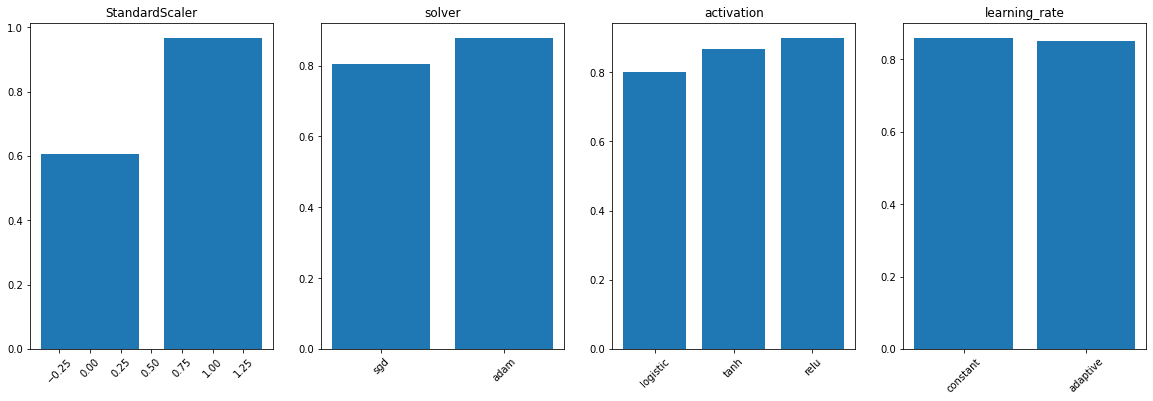

In [41]:
DicreetParamsMLP ={'StandardScaler':[0,1],
                'solver':['sgd','adam'],
                'activation':['logistic','tanh','relu'],
                'learning_rate':['constant','adaptive']}

BarPlotDicreetParams(DicreetParamsMLP,MLPs)

Βλέπουμε ότι το Standard Scaler είναι αραπαίτητο, ενώ με σχετικά μιρκή διαφορά υπερτερούν τα 

solver = adam

activation = relu

ενώ το learning rate είναι σχετικά το ίδιο.

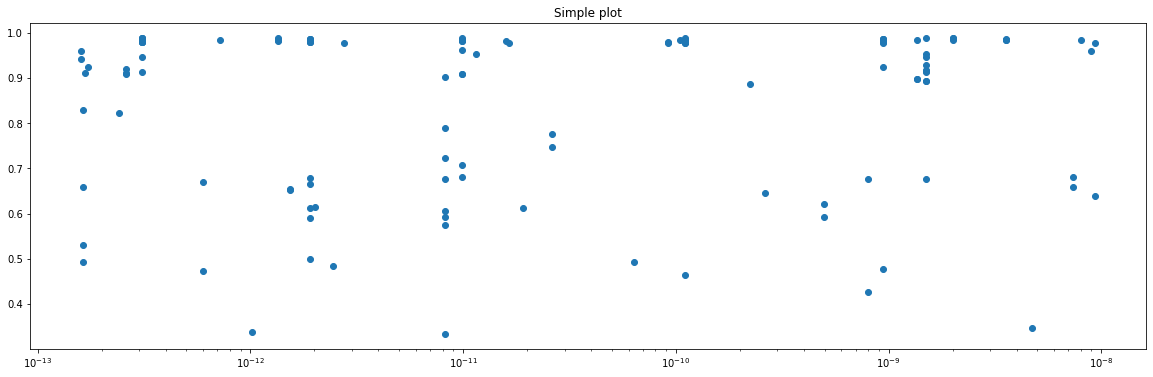

In [38]:
ContinuousVariable(MLPs,'alpha')

Τέλος η τιμή για το alpha δεν παίζει ιδιαίτερο ρόλο.

##SVC

for parameter : StandardScaler  value : 0  mean f1 score:  0.36825891303847297
for parameter : StandardScaler  value : 1  mean f1 score:  0.6311207241813721
for parameter : kernel  value : rbf  mean f1 score:  0.5265838114688783
for parameter : kernel  value : sigmoid  mean f1 score:  0.5149579118329163
for parameter : gamma  value : auto  mean f1 score:  0.5688786527580704
for parameter : gamma  value : scale  mean f1 score:  0.4684342550236522


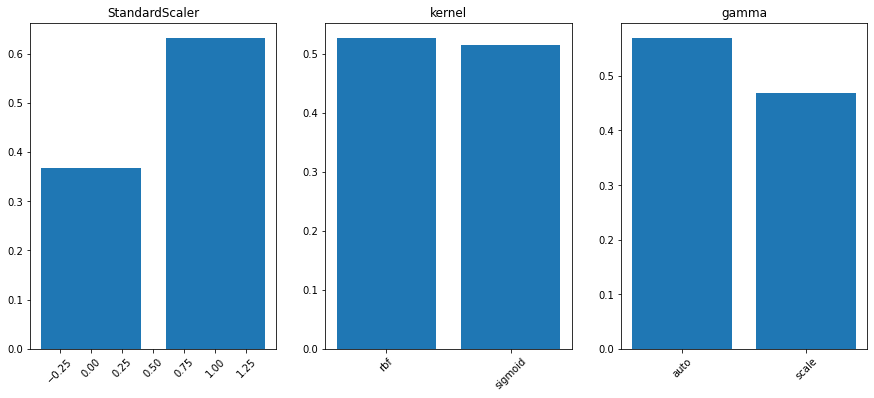

In [48]:
DicreetParamsSVC = {
    'StandardScaler':[0,1],
    'kernel':['rbf','sigmoid'],
    'gamma':['auto','scale']
}
BarPlotDicreetParams(DicreetParamsSVC,SVCs)

Ξαναβλέπουμε την σημασία του Standard Scaler, ενώ για kernel έχουμε rbf και gamma auto.

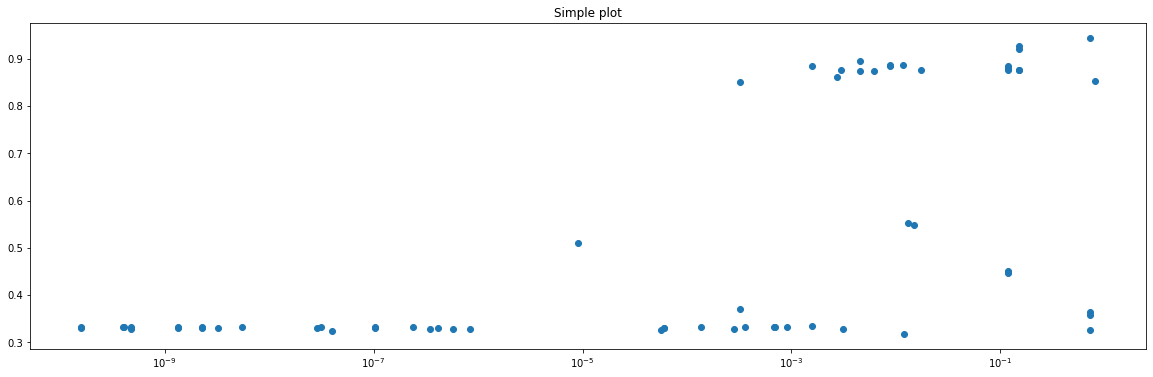

In [39]:
ContinuousVariable(SVCs,'C')

Ενώ βλέπουμε ότι θέλουμε το C να είναι μεγάλο

#Συμπεράσματα

Σε κάθε περίπρωση, ο ταξινομητής MLP είναι αρκεα καλύτερος για αυτό το dataset. Βλέπουμε ότι και στους δύο, είναι πολύ χρήσιμο το preprocessing, με το SMOTE και Standard Scaler, να κάνουν την μεγαλύτερη διαφορά.